# Use Catalog of Book Acquisitions from 1933-1940 to check missing book estimate

The Sylvia Beach archives include a catalog of book acquisitions from 1933-1940.

This notebook uses a spreadsheet of book data from that catalog compiled by Robert Chiossi under the guidance of Joshua Kotin to check missing book estimates.

In [21]:
import pandas as pd

# add project root to path so we can import utility methods
import sys
sys.path.append('..')

from utils.missing_data_processing import get_preprocessed_data, short_id, DATA_DIR


In [9]:
# load books and events dataset
data = get_preprocessed_data("books", "events") 
books_df = data["books"]
events_df = data["events"]

Summary information about book and borrowing information

- How many books were borrowed at least once?
- How many books are 'uncertain'?
- How many borrow events?
- How many borrow events, excluding uncertain titles?

*Note:* books that could not be positively identified by the Project team were flagged as `uncertain`; we exclude these from our analysis.

In [152]:

borrowed_books = books_df[books_df.borrow_count != 0]
total_borrowed_books = borrowed_books.shape[0]
total_borrowed_books

uncertain_books_df = books_df[books_df.uncertain]
total_uncertain_books = uncertain_books_df.shape[0]

# get all the borrow eventss
borrows = events_df[events_df.event_type == 'Borrow']

# exclude borrow events for uncertain titles
certain_borrows = borrows[~borrows.item_id.isin(uncertain_books_df.id)]
certain_borrows.shape[0]

print(f"""{total_borrowed_books:,} books borrowed at least once
{total_uncertain_books:,} uncertain books
{borrows.shape[0]:,} borrow events
{certain_borrows.shape[0]:,} borrow events for books that are not uncertain (i.e., identified titles)
""")

5,683 books borrowed at least once
475 uncertain books
21,059 borrow events
20,316 borrow events for books that are not uncertain (i.e., identified titles)



## Load acquisitions catalog data

We use a subset of fields from the working Project spreadsheet: author, title, publication date, item uri, and acquisition date.

In [23]:
catalog_df = pd.read_csv(DATA_DIR / "beach_lendinglibrary_catalog.csv")
# add short-form item id
catalog_df['item_id'] = catalog_df.item_uri.apply(short_id)
# parse acquisition date, which are mostly month precision
catalog_df['acq_date_dt'] = pd.to_datetime(catalog_df.acq_date, errors='coerce')
catalog_df.head()

,author,title,pub_date,item_uri,acq_date,item_id,acq_date_dt
0,"Morley, Christopher",Being Human: A Story,1932,https://shakespeareandco.princeton.edu/books/m...,1933-03,morley-human,1933-03-01
1,"Hurst, Fannie",Imitation of Life: A Novel,1933,https://shakespeareandco.princeton.edu/books/h...,1933-03,hurst-imitation-life,1933-03-01
2,"Aldington, Richard",All Men Are Enemies: A Romance,1933,https://shakespeareandco.princeton.edu/books/a...,1933-03,aldington-men-enemies,1933-03-01
3,"Anthony, Katharine",Marie Antoinette,1933,NaN,1933-03,None,1933-03-01
4,"Jackson, J. Hampden",Europe sInce the War: A Sketch of Political De...,1933,https://shakespeareandco.princeton.edu/books/j...,1933-03,jackson-europe-since-war,1933-03-01


### Trends in Beach's acquisitions

In [25]:
# how many acquisitions per month?
acq_weekly_count = catalog_df.groupby([pd.Grouper(key='acq_date_dt', freq='M')])['title'].count().reset_index()
acq_weekly_count.rename(columns={'title': 'total'}, inplace=True)
acq_weekly_count.head(10)

,acq_date_dt,total
0,1933-03-31,27
1,1933-04-30,12
2,1933-05-31,16
3,1933-06-30,10
4,1933-07-31,10
5,1933-08-31,0
6,1933-09-30,28
7,1933-10-31,16
8,1933-11-30,26
9,1933-12-31,11


<Axes: xlabel='acq_date_dt'>

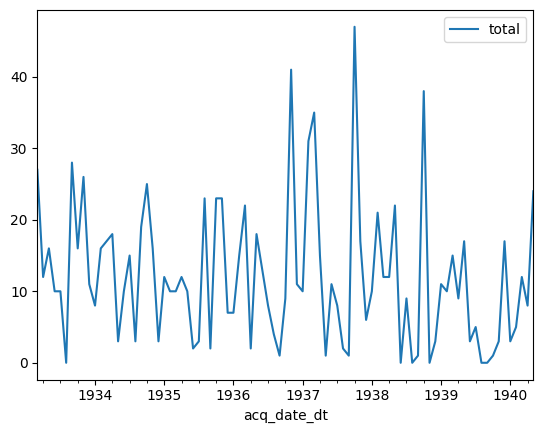

In [26]:
acq_weekly_count.plot.line(y='total', x='acq_date_dt')

In [27]:
acq_weekly_count.total.describe()

count    87.000000
mean     12.091954
std       9.931899
min       0.000000
25%       3.000000
50%      10.000000
75%      17.000000
max      47.000000
Name: total, dtype: float64

On average, Beach acquired 12 books per month. Theare are some months with zero acquisitions; others with as many as 47.

In [48]:
# which months had zero purchases?
acq_weekly_count[acq_weekly_count.total == 0]

,acq_date_dt,total
5,1933-08-31,0
63,1938-06-30,0
65,1938-08-31,0
68,1938-11-30,0
77,1939-08-31,0
78,1939-09-30,0


In [49]:
# which months had the most purchases?
acq_weekly_count.sort_values('total', ascending=False).head(5)

,acq_date_dt,total
55,1937-10-31,47
44,1936-11-30,41
67,1938-10-31,38
48,1937-03-31,35
47,1937-02-28,31


### How does the acquisition data compare to the book data?

Titles in the catalog without an item uri could not be linked to existing book data, thus are previously unknown titles.

In [57]:
# what dates does the catalog cover?
catalog_start_date = catalog_df.acq_date_dt.min()
catalog_end_date = catalog_df.acq_date_dt.max()

# how does the catalog compare to the library overall? 
catalog_total_books = catalog_df.shape[0]
catalog_total_books

# books without item uris were previously unknown
unknown_books = catalog_df[catalog_df.item_id.isna()]
total_unknown_books = unknown_books.shape[0]

# what percent of these books were previously unknown?
percent_unknown = total_unknown_books / catalog_total_books * 100


print(f"""Catalog covers {catalog_start_date.date()} to {catalog_end_date.date()}
{catalog_total_books:,} total books in the catalog
{total_unknown_books:,} books in the catalog not in Project book data
{percent_unknown:.2f}% percent of books previously unknown
""")

Catalog covers 1933-03-01 to 1940-05-01
1,055 total books in the catalog
106 books in the catalog not in Project book data
10.05% percent of books previously unknown



### Analyze borrowing activity for the dates covered by the catalog

In [61]:
# filter borrowing activity to this time period and check the books

# parse start date so we can compare
borrows['start_date_dt'] = pd.to_datetime(borrows['start_date'], errors='coerce')

# get all borrows after 1933-03-01 and before 1940-05-01
catalog_dates_borrows = borrows[borrows.start_date_dt >= catalog_start_date][borrows.start_date_dt <= catalog_end_date]

# how many unique books in this time?
len(catalog_dates_borrows.item_id.unique())

24

In [63]:
# are any of the books with ids not in this borrow data?
catalog_df[~catalog_df.item_id.isin(catalog_dates_borrows.item_id.unique())].head()

,author,title,pub_date,item_uri,acq_date,item_id,acq_date_dt
0,"Morley, Christopher",Being Human: A Story,1932,https://shakespeareandco.princeton.edu/books/m...,1933-03,morley-human,1933-03-01
1,"Hurst, Fannie",Imitation of Life: A Novel,1933,https://shakespeareandco.princeton.edu/books/h...,1933-03,hurst-imitation-life,1933-03-01
2,"Aldington, Richard",All Men Are Enemies: A Romance,1933,https://shakespeareandco.princeton.edu/books/a...,1933-03,aldington-men-enemies,1933-03-01
3,"Anthony, Katharine",Marie Antoinette,1933,NaN,1933-03,None,1933-03-01
4,"Jackson, J. Hampden",Europe sInce the War: A Sketch of Political De...,1933,https://shakespeareandco.princeton.edu/books/j...,1933-03,jackson-europe-since-war,1933-03-01


In [90]:
# what is the first borrow for each book in the catalog?
# create a subset of borrowing activity for catalog books only
catalog_borrows = borrows[borrows.item_id.isin(catalog_df.item_id)]
catalog_borrows.shape[0]

5149

In [95]:
# get the first borrow for each catalog book
# - convert start date to string so we can group
catalog_borrows['start_date_str'] = catalog_borrows.start_date.apply(lambda x: str(x))
catalog_first_borrows = catalog_borrows.groupby('item_id')['start_date_str'].min().reset_index()
# convert back to date time
catalog_first_borrows['start_date'] = pd.to_datetime(catalog_first_borrows["start_date_str"], format="ISO8601", errors='coerce')
# drop string column
catalog_first_borrows = catalog_first_borrows[['item_id', 'start_date']]
catalog_first_borrows.head()

,item_id,start_date
0,a-e-living-torch,1937-11-23
1,a-e-song-fountains,1934-01-22
2,abbe-around-world-eleven,1937-01-26
3,adamic-cradle-life-story,1937-04-14
4,adams-march-democracy-history,1933-05-11


In [97]:
# merge catalog information with catalog first borrows
catalog_borrowing = pd.merge(catalog_df, catalog_first_borrows.rename(columns={'start_date': 'first_borrow'}))
catalog_borrowing.head()

,author,title,pub_date,item_uri,acq_date,item_id,acq_date_dt,first_borrow
0,"Morley, Christopher",Being Human: A Story,1932,https://shakespeareandco.princeton.edu/books/m...,1933-03,morley-human,1933-03-01,1934-04-01
1,"Hurst, Fannie",Imitation of Life: A Novel,1933,https://shakespeareandco.princeton.edu/books/h...,1933-03,hurst-imitation-life,1933-03-01,1933-09-25
2,"Aldington, Richard",All Men Are Enemies: A Romance,1933,https://shakespeareandco.princeton.edu/books/a...,1933-03,aldington-men-enemies,1933-03-01,1933-04-01
3,"Jackson, J. Hampden",Europe sInce the War: A Sketch of Political De...,1933,https://shakespeareandco.princeton.edu/books/j...,1933-03,jackson-europe-since-war,1933-03-01,1933-05-29
4,"Sugimoto, Etsu Inaqaki",A Daughter of the Samurai: How a Daughter of F...,1925,https://shakespeareandco.princeton.edu/books/s...,1933-03,sugimoto-daughter-samurai,1933-03-01,1933-03-07


In [102]:
# which titles were borrowed before this catalog?
catalog_borrowing[catalog_borrowing.first_borrow < catalog_start_date][['author', 'title', 'pub_date', 'acq_date', 'first_borrow']]

,author,title,pub_date,acq_date,first_borrow
8,"Sitwell, Satcheverell",Mozart,1932,1933-03,1932-05-28
32,"Bennett, Arnold","The Journals of Arnold Bennett, Vol. 3. (1921-...",1932,1933-05,1932-07-20
44,"Oppenheim, E. Phillips",Murder at Monte Carlo,1933,1933-06,1933-02-19
45,"Terry, Ellen",Ellen Terry's Memoirs,1932,1933-06,1933-02-05
67,"Asquith, Margot",More Memories,1933,1933-09,1933-02-05
78,"Stein, Gertrude",The Autobiography of Alice B. Toklas,1933,1933-09,1933-01-15
83,"Macdonell, A.G.",The Shapkespeare Murders,1933,1933-10,1933-02-05
91,"Mantz, Ruth Elvish and John Middleton Murry",The Life of Katherine Mansfield,1933,1933-10,1933-01-30
104,"Whitehead, Alfred North",Adventures of Ideas,1933,1933-11,1933-01-22
125,"Patrick, Q",S. S. Murder,1933,1933-12,1933-02-14


In [104]:
# to estimate properly, really need to know % of borrowing activity for early period / late period and compare ...

# filter to all borrowing during this time period
borrows['year'] = borrows.start_date_dt.apply(lambda x: x.year if pd.notna(x) else None)
borrows[['start_date', 'end_date', 'member_names', 'item_title', 'year']].head()

,start_date,end_date,member_names,item_title,year
2,1922,1922-08-23,Mr. Rhys,Typhoon,1922.0
8,1923,1923-11-07,Eyre de Lanux / Mrs. Pierre de Lanux,Night and Day,1923.0
12,1924,1924-10-22,Simone Téry,James Joyce,1924.0
13,1924,1924-10-22,Simone Téry,A Portrait of George Moore in a Study of His Work,1924.0
22,1926,1926-01-14,Ada (Hitchcock) MacLeish;Archibald MacLeish,Tents of Israel,1926.0


In [72]:
def get_best_date(row):
  # dates are strings; return the longest
  start_date_len = len(row.start_date) if pd.notna(row.start_date) else 0
  end_date_len = len(row.end_date) if pd.notna(row.end_date) else 0

  if start_date_len > end_date_len:
    return row.start_date
  else:
    return row.end_date

# get either start or end date, whichever we find first

all_borrows = borrows.copy()
all_borrows['date'] = all_borrows.apply(get_best_date, axis=1)
all_borrows[['start_date', 'end_date', 'date']].head()

,start_date,end_date,date
2,1922,1922-08-23,1922-08-23
8,1923,1923-11-07,1923-11-07
12,1924,1924-10-22,1924-10-22
13,1924,1924-10-22,1924-10-22
22,1926,1926-01-14,1926-01-14


In [105]:
all_borrows['date_dt'] = pd.to_datetime(all_borrows.date, errors='coerce')

In [106]:
catalog_dates_borrows = all_borrows[all_borrows.date_dt >= catalog_start_date][all_borrows.date_dt <= catalog_end_date]
catalog_dates_borrows.shape[0]

10747

In [112]:
catalog_dates_borrows.sort_values('date_dt')[['date', 'member_names', 'item_title']].head()

,date,member_names,item_title
13662,1933-03-01,Donald Culver,The Adventures of Tom Sawyer
13659,1933-03-01,Aline Prot,The Gods Arrive
13646,1933-03-01,Donald Culver,Conquistador
13671,1933-03-03,Countess de Vogué,Invitation to the Waltz
13665,1933-03-03,Thérèse Tony-Mayer,Light in August


In [143]:
# how many total borrow events for these dates?

catalog_dates_total_borrows = catalog_dates_borrows.shape[0]
catalog_dates_total_items = len(catalog_dates_borrows.item_id.unique())

# how many events with uncertain titles?
uncertain_catalog_dates_borrows = catalog_dates_borrows[catalog_dates_borrows.item_id.isin(uncertain_books_df.id)]

print(f"""Borrowing activity for dates covered by the catalog:
{catalog_dates_total_borrows:,} total borrows
{catalog_dates_total_items:,} unique titles
{uncertain_catalog_dates_borrows.shape[0]:,} borrows for uncertain titles
{len(uncertain_catalog_dates_borrows.item_id.unique()):,} unique uncertain titles
""")

Borrowing activity for dates covered by the catalog:
10,747 total borrows
3,362 unique titles
307 borrows for uncertain titles
190 unique uncertain titles



In [147]:
# there are enough uncertain titles that we should filter them out
certain_catalog_dates_borrows = catalog_dates_borrows[~catalog_dates_borrows.item_id.isin(uncertain_books_df.id)]
certain_catalog_dates_total_borrows = certain_catalog_dates_borrows.shape[0]
certain_catalog_dates_total_items = len(certain_catalog_dates_borrows.item_id.unique())

print(f"""Borrowing activity for dates covered by the catalog:
{certain_catalog_dates_borrows.shape[0]:,} total borrows for identified titles
{len(certain_catalog_dates_borrows.item_id.unique()):,} unique identified titles
""")

Borrowing activity for dates covered by the catalog:
10,440 total borrows for identified titles
3,172 unique identified titles



In [120]:
# what percent of those titles are included in the catalog?
# limit to borrow events for items in the catalog
certain_catalog_dates_catalog_borrows = certain_catalog_dates_borrows[certain_catalog_dates_borrows.item_id.isin(catalog_df.item_id)]
certain_catalog_dates_catalog_borrows[['date', 'member_names', 'item_title']].head()

,date,member_names,item_title
149,1937-06-01,Fernand Colens,The Friendly Tree
150,1937-12-08,Fanny Rirachowsky,Poems
156,1938-06-23,Thérèse Bertrand-Fontaine,To Wake the Dead
168,1938-06-25,Thérèse Bertrand-Fontaine,Enchanter's Nightshade
171,1938-05-16,Vincens,The Secret War: The War for Oil


In [142]:
# how many events, how many titles? (for identified items)
catalog_dates_catalog_total_borrows = certain_catalog_dates_catalog_borrows.shape[0]
catalog_dates_catalog_total_items = len(certain_catalog_dates_catalog_borrows.item_id.unique())

print(f"""Borrowing activity for dates covered by the catalog AND titles included in the catalog:
{catalog_dates_catalog_total_borrows:,} total borrows 
{catalog_dates_catalog_total_items:,} unique identified titles
""")

Borrowing activity for dates covered by the catalog AND titles included in the catalog:
4,316 total borrows 
881 unique identified titles



In [150]:
# what percent of the circulation is that?
# catalog_dates_total_borrows = catalog_dates_borrows.shape[0]
# just work with the certain ones, for simplicity
catalog_dates_catalog_total_borrows = certain_catalog_dates_catalog_borrows.shape[0]
catalog_dates_catalog_total_items = len(certain_catalog_dates_catalog_borrows.item_id.unique())

# catalog books account for what % of borrowing activity during this time?
percent_borrowing_activity = catalog_dates_catalog_total_borrows / certain_catalog_dates_total_borrows

# what % of books in circulation?
percent_books = catalog_dates_catalog_total_items / catalog_dates_total_items

print(f"""Borrowing activity for identifed titles during dates covered by the catalog AND titles included in the catalog:
{certain_catalog_dates_catalog_borrows.shape[0]:,} total borrows 
{catalog_dates_total_items:,} unique identified titles
{percent_borrowing_activity*100:.1f}% of borrowing activity from catalog titles
{percent_books*100:.1f}% of books from catalog titles
""")

Borrowing activity for identifed titles during dates covered by the catalog AND titles included in the catalog:
4,316 total borrows 
3,172 unique identified titles
41.3% of borrowing activity from catalog titles
27.8% of books from catalog titles

